# Исследование закономерностей, определяющих успешность видеоигры. 

Определение потенциально популярных продуктов и их характеристик в видеоигровой индустрии для планирования рекламных компаний интернет магазина "Стримчик".

## Открытие файла с данными и получение первостепенной информации

**1.1 Импорт библиотеки, открытие файла**

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    print('Проверьте путь к файлу')

**1.2 Вывод первых пяти строк**

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**1.3 Вывод общей информации о DataFrame**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**1.4 Проверка на дубликаты**

In [5]:
data.duplicated().sum()

0

Полных дубликатов не обнаружено.

In [6]:
try:
    print(len(data['Name'].unique()) == len(data.Name.str.lower().unique()))
except:
    print(len(data['name'].unique()) == len(data.name.str.lower().unique()))

True


Это говорит об отсутствии одинаковых названий с различным регистром.

## Предобработка данных

**2.1 Замена названий столбцов**

In [7]:
data.columns = [x.lower() for x in data.columns]
#привели названия к нижнеиу регистру

**2.2 Изменение типов данных столбцов** <br>

Столбцы с типом данных, не соответсвующие содержащимся в них данных: <br>
- **year_of_release** имеет формат float64 при целочисленных значениях лет
- **critic_score** имеет формат float64 при целочисленных значениях оценок критиков
- **user_score** имеет формат object при действительных значениях оценок игроков

Исправить типы данных первых двух столбцов неовзможно из-за большого количества пропусков Nan, которые имеют тип float64. Что касается столбца **user_score**, в нём помимо чисел содержится значение tbd (будет определено позже), имеющее тип object. Так как это значение неизвестно, его можно заменить на Nan и сменить тип данных столбца на float64.

In [8]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

In [9]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [10]:
data['user_score'] = data['user_score'].astype(float)

**2.3 Добавление столбца с числом общих продаж**

In [11]:
data['all_sales']=data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

**2.4 Обработка пропусков**

In [12]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
all_sales             0
dtype: int64

Пропуски в данных могут возникать в следствии ошибок кодировки файла; отсутствия данных как таковых на данный момент времени; человеческий фактор. <br>

Заполнить данные в столбцах **name**, **rating** не представляется возможным; <br>
Оценки критиков и игроков хоть и не возможно предугадать для определённого продукта, так как она зависит от качества самого продукта и временной период выпуска в мир. Так же невозможно оценить их исходя из количества продаж по всему миру, так как оценки качества игры и количество продаж не зависят друг от друга, а сами продажи зависят от множества других факторов.


In [13]:
data = data.loc[~data['year_of_release'].isna()]
data = data.loc[~data['genre'].isna()]
data = data.loc[~data['name'].isna()]
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
all_sales             0
dtype: int64

In [14]:
data['year_of_release'] = data['year_of_release'].astype(int)

Выясним количество различных рейтингов игр и очистим данные от пренебрежимо малых значений.

In [15]:
data.groupby('rating')['name'].count()

rating
AO         1
E       3921
E10+    1393
EC         8
K-A        3
M       1536
RP         1
T       2905
Name: name, dtype: int64

In [16]:
data = data.query('rating != ("AO", "EC", "K-A", "RP")')
data.groupby('rating')['name'].count()

rating
E       3921
E10+    1393
M       1536
T       2905
Name: name, dtype: int64

Выясним зависимость продаж от оценки игроков и критиков.


Text(0, 0.5, 'Продажи млн. копий')

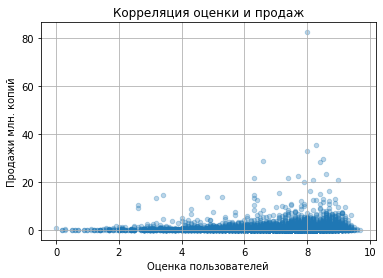

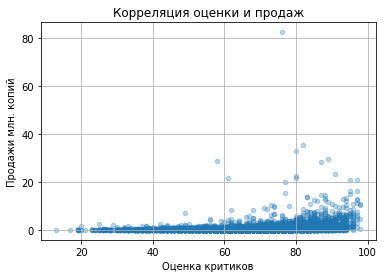

In [17]:
data.plot(kind='scatter', x='user_score', y='all_sales', grid=True, alpha=0.3).set_title('Корреляция оценки и продаж');
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи млн. копий')
data.plot(kind='scatter', x='critic_score', y='all_sales', grid=True, alpha=0.3).set_title('Корреляция оценки и продаж');
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи млн. копий')

По графику видно, что хоть с увеличением оценки количество продаж может расти, но плотность количества оценок на низком уровне продаж так же высока, как и на больших продажах, что говорит об очень малой корреляции.

In [18]:
print('Уровень корреляции -', data['user_score'].corr(data['all_sales']))

Уровень корреляции - 0.08778623289601402


***Что и требовалось доказать***

## Исследовательский анализ данных

**3.1 Подсчёт выпуска игр в разные годы**

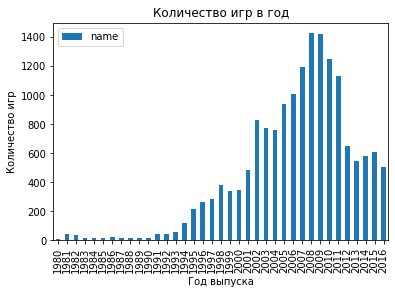

In [19]:
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar').set_title('Количество игр в год');
plt.xlabel('Год выпуска');
plt.ylabel('Количество игр');

In [20]:
data = data.query('year_of_release > 1994')

**3.2 Наибольшие продажи по платформам**

In [21]:
data.groupby('platform')['all_sales'].sum().sort_values(ascending=False).head(10)

platform
PS2     1233.32
X360     961.24
PS3      931.34
Wii      890.52
DS       802.11
PS       719.64
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: all_sales, dtype: float64

Построим распределение по годам среди платформ с самыми большими продажами.

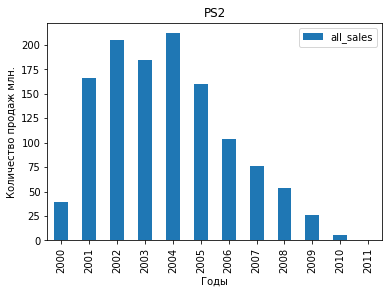

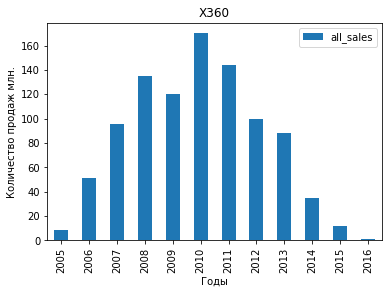

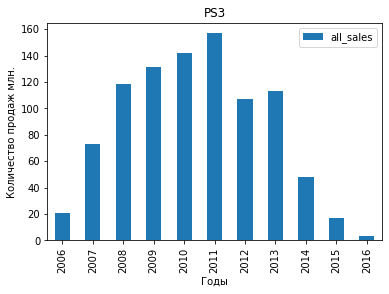

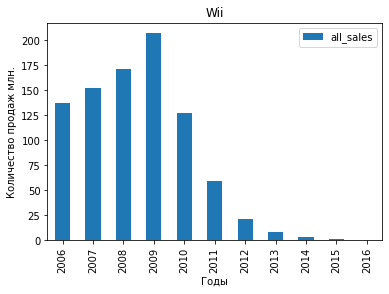

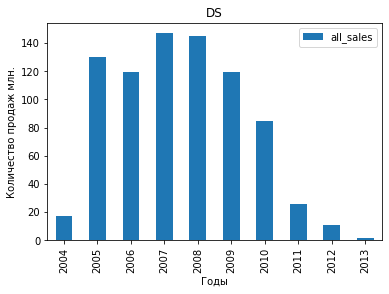

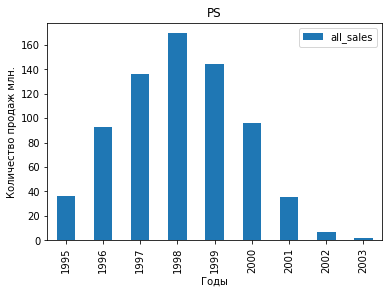

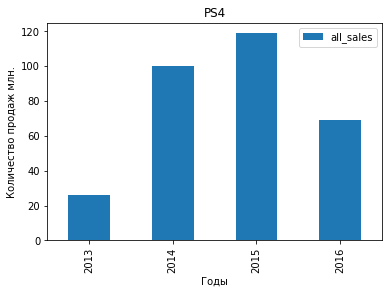

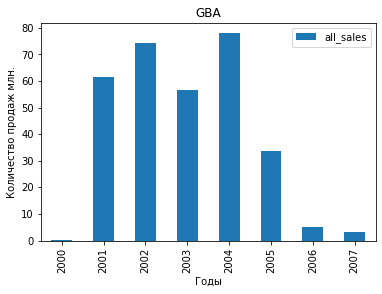

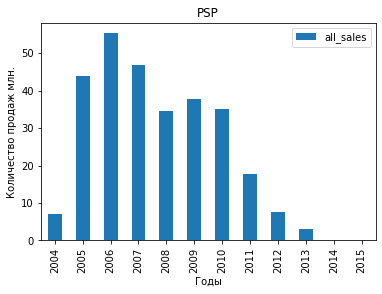

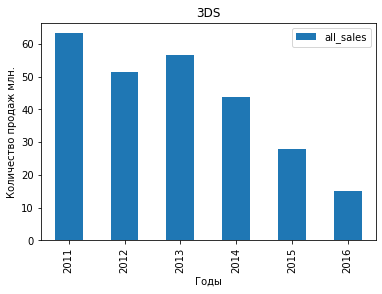

In [22]:
platform = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']
for i in platform:
    data[data['platform'] == i].pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').plot(kind='bar', title=i)
    plt.xlabel('Годы')
    plt.ylabel('Количество продаж млн.')

Как видно из графиков, среднее время жизни платформы около десяти лет, а зарождение нового поколения консоли происходит за пару лет до смерти предыдущего.

**3.3 Возьмём данные за актуальный период времени**

In [23]:
data = data.query('year_of_release > 2012')

**3.4 Определим прибыльность, рост и падение платформ**

In [24]:
data.groupby('platform')['all_sales'].sum().sort_values(ascending=False).to_frame()

,all_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


Самые большие продажи приходятся на консоли нового поколения, которые на момент сбора данных уже начали опережать предыдущие поколения (за исключением PS3, которая всё ещё востребована). <br>
Исходя из графиков предыдущего пункта можно определить, что такие платформы, как: PS2, Wii, DS, GBA, PSP, XB на момент сбора информации практически умерли и уже не получают крупные прибыли. А из тех, кто попал по прибыльности в топ десять платформ, это: PS4, PS3, XOne - что говорит об их перспективности. <br>
Для большей точности узнаем, на каких платформах и сколько выходит игр в год.

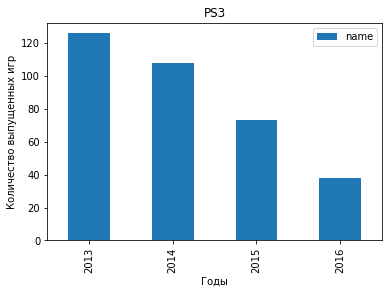

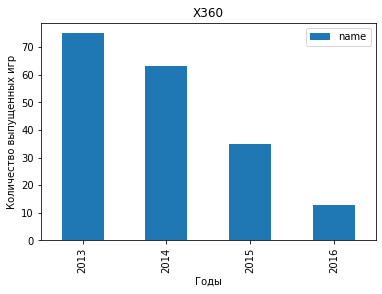

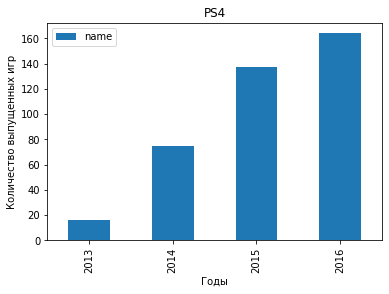

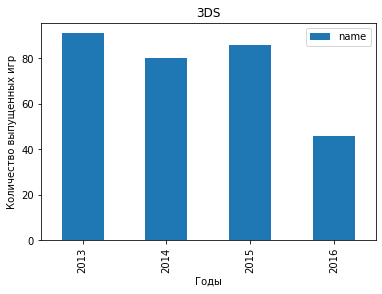

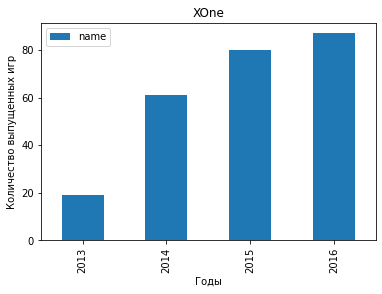

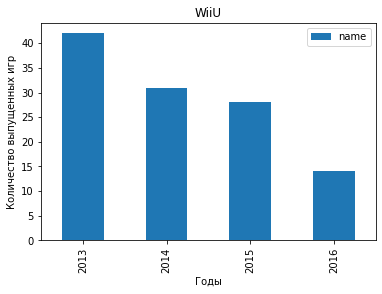

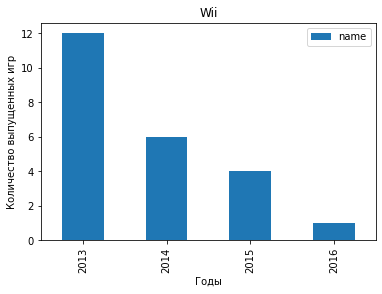

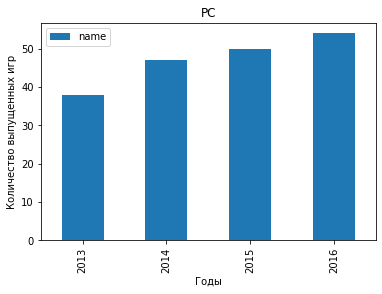

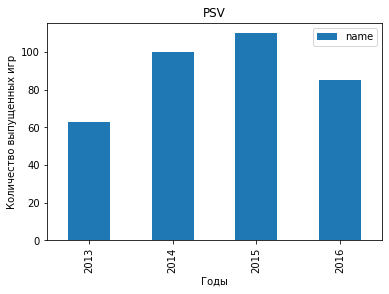

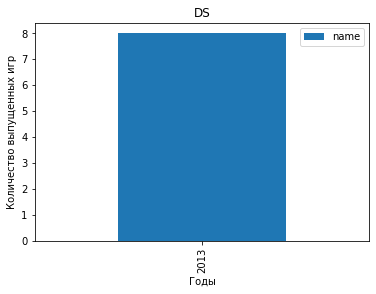

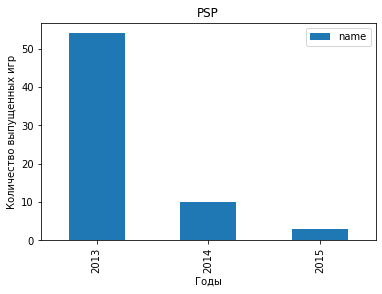

In [25]:
for i in data['platform'].unique():
    data[data['platform'] == i].pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar', title=i)
    plt.xlabel('Годы')
    plt.ylabel('Количество выпущенных игр')

**Возрастающий тренд виден у PS4, PC, XOne, PSV. Умеренно спадающий у 3DS и WiiU. Это говорит о большой перспективности таких платформ как PS4, PC и XOne и умеренной перспективности 3DS.**

**3.5 Построение графика "ящик с усами" по глобальным продажам игр в разбивке по платформам**

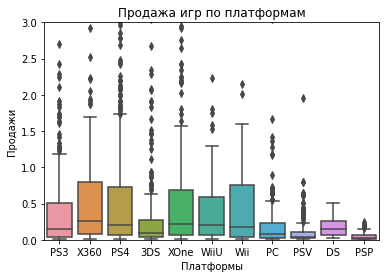

<Figure size 1080x1080 with 0 Axes>

In [26]:
plt.figure(figsize=(15,15))
sns.boxplot(x='platform', y='all_sales', data=data).set_ylim(0,3)
plt.title('Продажа игр по платформам')
plt.xlabel('Платформы')
plt.ylabel('Продажи');

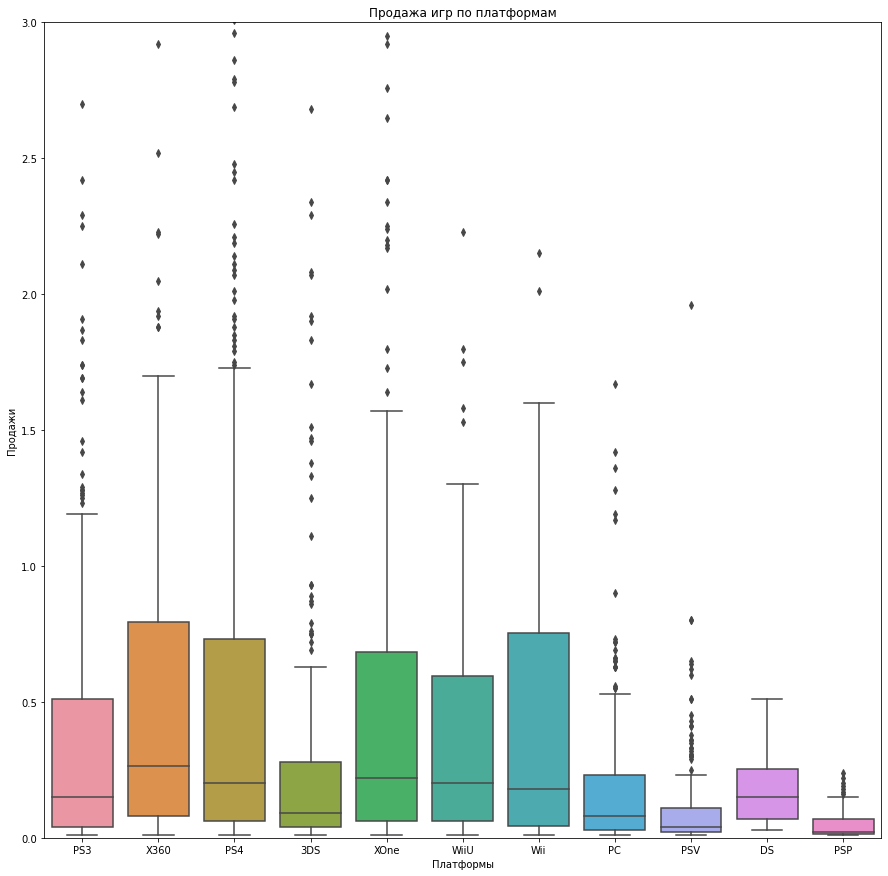

In [46]:
plt.figure(figsize=(15,15))
sns.boxplot(x='platform', y='all_sales', data=data).set_ylim(0,3)
plt.title('Продажа игр по платформам')
plt.xlabel('Платформы')
plt.ylabel('Продажи');

Можно заметить, что наибольшие продажи по медиане имеют таки платформы, как X360, XOne и WiiU. Очень много продаж между медианой и третьем квартилем у X360, XOne, Wiiu, Wii, PS4, что говорить об неравномености распределения между низкими продажами и высокими у этих платформ. По второму графику можно видеть, что наибольшее количество выбросов, то есть игр с продажами сильно выше обычного есть у платформ предыдущего поколения PS3, X360, 3DS, а так же нового PS4, что может говорить об большом асортименте выпускаемых игр по сравнению с другими, что увеличивает шанст, что одна из них может выстрелить сильнее всех остальных.

**3.6 Корреляция между отзывами и продажами**

Возьмём для примера одну из популярных платформ - PS4. 

Уровень корреляции с оценкой игроков - -0.031957110204556376
Уровень корреляции с оценкой критиков - 0.40656790206178095


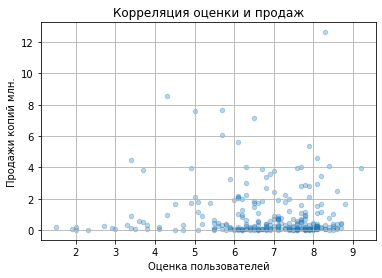

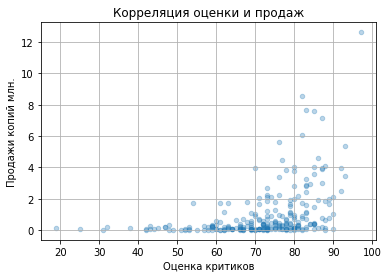

In [28]:
data.loc[data['platform'] == 'PS4'].plot(kind='scatter', x='user_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи копий млн.')
data.loc[data['platform'] == 'PS4'].plot(kind='scatter', x='critic_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи копий млн.')
print('Уровень корреляции с оценкой игроков -', data.loc[data['platform'] == 'PS4']['user_score'].corr(data['all_sales']))
print('Уровень корреляции с оценкой критиков -', data.loc[data['platform'] == 'PS4']['critic_score'].corr(data['all_sales']))

Можно сделать вывод, что хоть зависимосимость есть, но она слишком маленькая, чтобы по оценкам из выборки игроков или критиков можно было бы сделать предсказание о количестве проданных копий игры в будущем. Вывод из пункта 2.4 по всей выборке в целом подтвердился в частности для конкретной платформы.

**3.7 Сравним с графиками рассеивания других платформ**

Возьмём PC, 3DS, XOne, X360

Уровень корреляции с оценкой игроков - -0.0938418695247674
Уровень корреляции с оценкой критиков - 0.19603028294369382


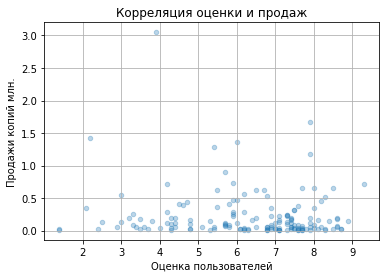

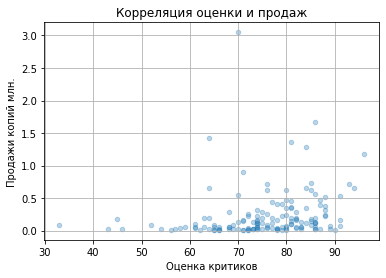

In [29]:
data.loc[data['platform'] == 'PC'].plot(kind='scatter', x='user_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи копий млн.')
data.loc[data['platform'] == 'PC'].plot(kind='scatter', x='critic_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи копий млн.')
print('Уровень корреляции с оценкой игроков -', data.loc[data['platform'] == 'PC']['user_score'].corr(data['all_sales']))
print('Уровень корреляции с оценкой критиков -', data.loc[data['platform'] == 'PC']['critic_score'].corr(data['all_sales']))

Уровень корреляции с оценкой игроков - 0.24150411773563016
Уровень корреляции с оценкой критиков - 0.3570566142288103


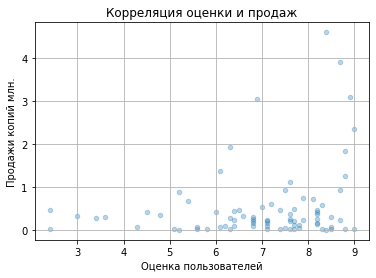

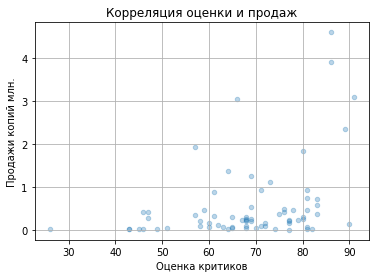

In [30]:
data.loc[data['platform'] == '3DS'].plot(kind='scatter', x='user_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи копий млн.')
data.loc[data['platform'] == '3DS'].plot(kind='scatter', x='critic_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи копий млн.')
print('Уровень корреляции с оценкой игроков -', data.loc[data['platform'] == '3DS']['user_score'].corr(data['all_sales']))
print('Уровень корреляции с оценкой критиков -', data.loc[data['platform'] == '3DS']['critic_score'].corr(data['all_sales']))

Уровень корреляции с оценкой игроков - -0.06892505328279414
Уровень корреляции с оценкой критиков - 0.4169983280084017


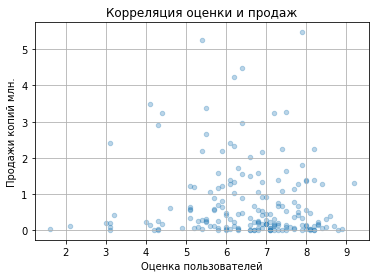

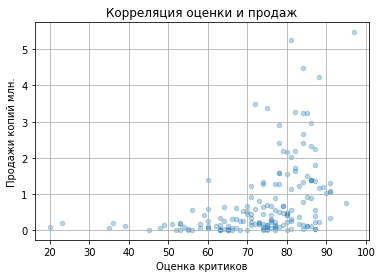

In [31]:
data.loc[data['platform'] == 'XOne'].plot(kind='scatter', x='user_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи копий млн.')
data.loc[data['platform'] == 'XOne'].plot(kind='scatter', x='critic_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи копий млн.')
print('Уровень корреляции с оценкой игроков -', data.loc[data['platform'] == 'XOne']['user_score'].corr(data['all_sales']))
print('Уровень корреляции с оценкой критиков -', data.loc[data['platform'] == 'XOne']['critic_score'].corr(data['all_sales']))

Уровень корреляции с оценкой игроков - -0.011742185147181342
Уровень корреляции с оценкой критиков - 0.3503445460228664


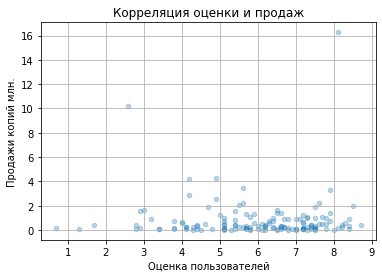

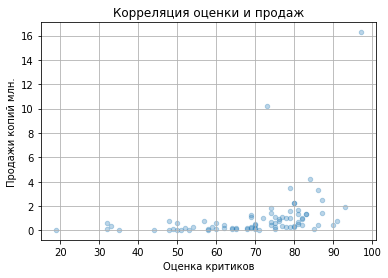

In [32]:
data.loc[data['platform'] == 'X360'].plot(kind='scatter', x='user_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи копий млн.')
data.loc[data['platform'] == 'X360'].plot(kind='scatter', x='critic_score', y='all_sales', grid=True, alpha=0.3);
plt.title('Корреляция оценки и продаж');
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи копий млн.')
print('Уровень корреляции с оценкой игроков -', data.loc[data['platform'] == 'X360']['user_score'].corr(data['all_sales']))
print('Уровень корреляции с оценкой критиков -', data.loc[data['platform'] == 'X360']['critic_score'].corr(data['all_sales']))

Координально отличий в коррелчции и графиках нет, но прослеживается тенденция, что оценка критиков более коррелируют с количеством продаж, чем оценка игроков, которая зачастую очень слабая, или даже отрицательная, но корреляция между продажами и оценками критиков - слабая.

**3.8 Распределение игр по жанрам**

In [33]:
data.pivot_table(index='genre', values='all_sales', aggfunc=['count', 'median', 'mean']).sort_values(by=('median', 'all_sales'), ascending=False)

,count,median,mean
,all_sales,all_sales,all_sales
genre,,,
Shooter,187,0.450,1.245882
Sports,214,0.240,0.703972
Platform,74,0.225,0.576081
Role-Playing,292,0.125,0.499623
Fighting,80,0.125,0.441375
Racing,85,0.120,0.469294
Action,766,0.110,0.420196
Simulation,62,0.100,0.350968


Лидиром среди жанров в последние года стали шутеры, платформеры и спортсимы. их средняя и медиана по продажам больше всех остальных. Самыми выпускаемыми играми являются игры жанра экшн, но их медиана продаваемости не велика. <BR>
    
Среди жанров аутсайдеров такие как стратегии и пазлы как в ценовом, так и в количественном отношении.
    

## Составление портрета пользователя

**4.1 Определение популярности платформ**

Выясним суммарные продажи по каждой платформе для каждого региона и оставим топ-5 платформ.

In [34]:
display(data.pivot_table(index='platform', values=['na_sales'], aggfunc='sum')
        .sort_values(by='na_sales', ascending=False).head(5))
display(data.pivot_table(index='platform', values=['eu_sales'], aggfunc='sum')
        .sort_values(by='eu_sales', ascending=False).head(5))
display(data.pivot_table(index='platform', values=['jp_sales'], aggfunc='sum')
        .sort_values(by='jp_sales', ascending=False).head(5))

#подскажите, как можно вывести талбицы не друг под другом, а в ряд.

,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


Самые большие продажи приходятся на Северную Америку. Самые популярные платформы: PS4, XOne и X360. В сумме около трёхсот тысяч продаж. <br>
В Европе пальму первенства удерживают платформы PS4 и PS3, X360 занимает лишь четвёртое место. <br>
В Японии первое место по проданным на эту платформу игр занимает 3DS, что занимала последние места в топе как в Европе, так и в Америке. Суммарное количество продаж в Японии ниже чем на остальных рынках и больше отличается от них, чем они друг от друга, однако и здесь платформы PS4 и PS3 вошли в топ-5 игровых платформ.

**4.2 Определение популярности жанров**

Выясним суммарные продажи по каждому жанру для каждого региона и оставим топ-5 жанров видеоигр.

In [35]:
display(data.pivot_table(index='genre', values=['na_sales'], aggfunc='sum')
        .sort_values(by='na_sales', ascending=False).head(5))
display(data.pivot_table(index='genre', values=['eu_sales'], aggfunc='sum')
        .sort_values(by='eu_sales', ascending=False).head(5))
display(data.pivot_table(index='genre', values=['jp_sales'], aggfunc='sum')
        .sort_values(by='jp_sales', ascending=False).head(5))

,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


Здесь как и с платформами так же заметно, что Американский рынок занимает первое место по продажам, затем идёт Европа и только потом Япония. Так же снова видно, что Японский рынок отличается от Европейского и Американского рынков. <br>
Самыми популярными жанрами Европы и Америки являются экшн, спортивные симуляторы и шутеры. Хоть в Японии так же популярны экшн, однако он расположен лишь на втором месте. Первое место занимает Role-Playing, который в Америке и Европе занимает четвёртое место.

**4.3 Влияние возрастного рейтинга на продажи в регионе**

In [36]:
data.loc[data['rating'].isna(), 'rating'] = 'Not'
#заменили пропуски в категориях играх 

In [37]:
display(data.pivot_table(index='rating', values=['na_sales'], aggfunc='sum')
        .sort_values(by='na_sales', ascending=False))
display(data.pivot_table(index='rating', values=['eu_sales'], aggfunc='sum')
        .sort_values(by='eu_sales', ascending=False))
display(data.pivot_table(index='rating', values=['jp_sales'], aggfunc='sum')
        .sort_values(by='jp_sales', ascending=False))

,na_sales
rating,
M,165.21
Not,89.42
E,79.05
E10+,54.24
T,49.79


,eu_sales
rating,
M,145.32
E,83.36
Not,78.91
E10+,42.69
T,41.95


,jp_sales
rating,
Not,85.05
T,20.59
E,15.14
M,14.11
E10+,5.89


Можно заметить сильную схожесть между количеством проданных копий игр определённого рейтинга во всех регионах. Так рейтинг М возглвляет таблицу по продажам во всех регионах кроме Японии. <br>
Так же можно заметить, что в Японском сегменте игры рейтинга M (17+) покупаются менее охотно, чем на западе.
Однако игры без категории так же очень распространены в западном полушарии, а в Японии занимают первое место с отрывом в 4 раза, что говорит о сильной распространённости таких игр.

## Проверка гипотез

**5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**


Сформулируем две гипотезы. Нулевая гипотеза: средняя оценка пользователей игр на Xbox One равна PC. Альтернативная: средняя оценка пользователей игр на Xbox One не равна PC.

In [38]:
table_pc = list(data.loc[data['platform'] == 'PC']['user_score'].dropna())
table_xone = list(data.loc[data['platform'] == 'XOne']['user_score'].dropna())

alpha = .01

results = st.ttest_ind(
    table_pc, 
    table_xone)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Проведя T-test, мы пришли к выводу о том, что среднее двух выборок равны. Мы задали пороговое значение в 1%.

In [39]:
print('Средний рейтинг PC:', round(data.loc[data['platform'] == 'PC']['user_score'].mean(), 2))
print('Средний рейтинг XOne:', round(data.loc[data['platform'] == 'XOne']['user_score'].mean(), 2))

Средний рейтинг PC: 6.27
Средний рейтинг XOne: 6.52


**5.2 Средние пользовательские рейтинги жанров Action и Sports разные**

Сформулируем две гипотезы. Нулевая гипотеза: средняя оценка пользователей игр жанра Action равна Sports. Альтернативная: средняя оценка пользователей игр жанра Action не равна Sports.

In [40]:
table_action = list(data.loc[data['genre'] == 'Action']['user_score'].dropna())
table_sports = list(data.loc[data['genre'] == 'Sports']['user_score'].dropna())

alpha = .01

results = st.ttest_ind(
    table_action, 
    table_sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Можно сделать вывод о неправильности нашей гипотезы, так как критический уровень статистической значимости больше, чем полученное значение, следовательно средние рейтинги этих жанров не равены друг другу.

In [41]:
print('Средний рейтинг Action:', round(data.loc[data['genre'] == 'Action']['user_score'].mean(), 2))
print('Средний рейтинг Sports:', round(data.loc[data['genre'] == 'Sports']['user_score'].mean(), 2))

Средний рейтинг Action: 6.84
Средний рейтинг Sports: 5.24


## Общий вывод

**Было проведено исследование для выявления определяющих успешность игры закономерностей. Входные данные - исторические данные о продаже игр из открытых источников.**

**Перед началом исследования были поставлены задачи:**
- Выявить факторы, влияющие успешность игры;
- Нарисовать портрет игрока из различных регионов мира;
- Проверить две гипотезы о равенстве оценко игроков двух платформ и двух игровых жанров.


**В результате проведённого исследования были выявлены следующие закономерности:**

1) По оценке игроков и экспертов нельзя предсказать успешность того или иного продукта <br/>
2) Среднее время жизни платформы около десяти лет, а зарождение нового поколения консоли происходит за пару лет до смерти предыдущего. <br/>
3) Возрастающий тренд выпуска игр и продаж виден у таких платформ, как: PS4, PC, XOne, PSV. Умеренно спадающий у 3DS и WiiU. Это говорит о большой перспективности таких платформ как PS4, PC и XOne и умеренной перспективности 3DS <br/>
4) В разных частях света интерес к игровым платформам и игровым жанрам несколько разнится. Это необходимо учитывать при планировании рекламной компании той или иной игры. <br/>


**Проверка двух гипотез показала, что:**

- Средние пользовательские рейтинги двух игровых платформ Xbox one и PC одинаковы: <br> 
    Средний рейтинг PC и Xbox one около 6.4 <br>
- Средние пользовательские рейтинги жанров Action и Sports не одинаковы: <br>
    Средний рейтинг Action: 6.84 <br>
    Средний рейтинг Sports: 5.24 <br>
    

**Планирование рекламной компании должно опираться на:**

1) Любимые жанры американцев и европейцев - Action, Sports, Shooter. Японцев - Action и Role-Playing <br/>
2) Любимые платформы западного полушария - PS3, PS4, XOne . На Японском рынке лидирует платформа 3DS <br/>
3) При выходе на Японском рынке игры с более низким возростным рейтингом продаются лучше, чем с высоким. На западе ровно наоборот. Но особенно хорошо продаются игры без рейтинга, что тоже нельзя не учитывать.<br/>

**Общие рекомендации:**
При оценке успешности игры и запуске рекламной компании необходимо операться на вышеописанную характеристику регионального геймера и больше продвигать игры на соответствующих популярных в регионе платформах, соответствующего региону жанра и соответсвтующего региону возрастного ограничения.